In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
import pandas as pd
import os
import zipfile
import shutil

Data_dir = '/content/nearest_earth_objects'

if os.path.exists(Data_dir):
  shutil.rmtree(Data_dir)

with zipfile.ZipFile('/content/nearest_earth.zip','r') as file:
  file.extractall(Data_dir)
data = pd.read_csv(os.path.join(Data_dir,'neo.csv'))

In [ ]:
data.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90836 entries, 0 to 90835
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  90836 non-null  int64  
 1   name                90836 non-null  object 
 2   est_diameter_min    90836 non-null  float64
 3   est_diameter_max    90836 non-null  float64
 4   relative_velocity   90836 non-null  float64
 5   miss_distance       90836 non-null  float64
 6   orbiting_body       90836 non-null  object 
 7   sentry_object       90836 non-null  bool   
 8   absolute_magnitude  90836 non-null  float64
 9   hazardous           90836 non-null  bool   
dtypes: bool(2), float64(5), int64(1), object(2)
memory usage: 5.7+ MB


In [ ]:
data = data.drop(['orbiting_body','sentry_object','name'],axis=1)

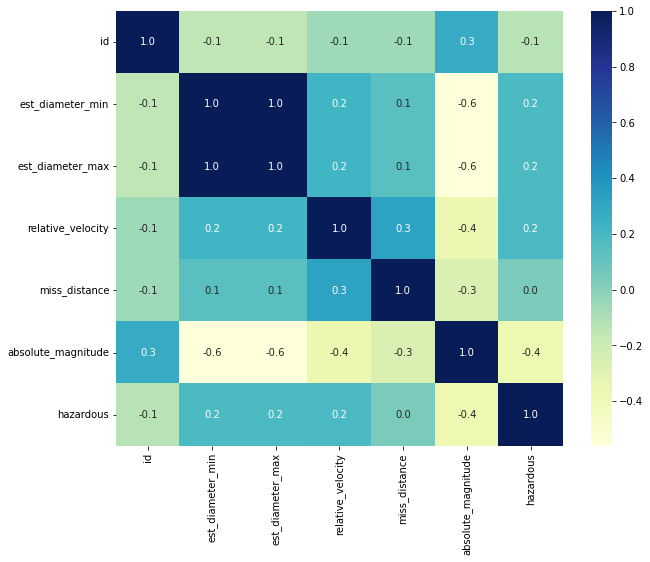

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder ,StandardScaler

scaler = StandardScaler()
label = LabelEncoder()
label = label.fit_transform(data['hazardous'])

plt.figure(figsize=(10,8))
corr = data.corr()
sns.heatmap(corr,annot=True,fmt='.1f',cmap='YlGnBu')

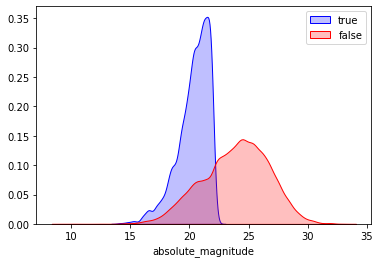

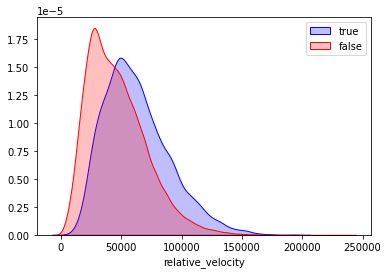

In [ ]:
true_data =  data[data['hazardous'] == True]
false_data = data[data['hazardous'] == False]
x = data.drop(['hazardous'],axis=1)
x = scaler.fit_transform(x)
y = label

def columns_plot(columns):
  sns.kdeplot(true_data[columns],color='blue',label='true',shade=True)
  sns.kdeplot(false_data[columns],color='red',label='false',shade=True)
  plt.xlabel(columns)
  plt.ylabel("")
  plt.legend()
  plt.show()

columns_plot('absolute_magnitude')
columns_plot('relative_velocity')

In [ ]:
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size =0.2,random_state = 34)

models = [('rf',RandomForestClassifier()),('gb',GradientBoostingClassifier()),('kn',KNeighborsClassifier())]

score_rank =pd.Series(dtype='float64')

for n , m in models:
  name = n
  model = m

  model.fit(x_train,y_train)
  score = model.score(x_test,y_test)

  score_rank=pd.concat([score_rank,pd.Series([score],index = [name])])

print(score_rank)


rf    0.953104
gb    0.922006
kn    0.904392
dtype: float64


In [ ]:
from sklearn.model_selection import RandomizedSearchCV , KFold

kf = KFold()

rf_model = models[0][1]
gb_model = models[1][1]
kn_model = models[2][1]

rf_params = {'n_estimators' : [80,100,120,140],'criterion' : ['gini','entropy'],'min_samples_split' : [2,3,4]}
gb_params = {'n_estimators' : [80,100,120],'max_depth' : [3,4,5],'learning_rate' : [0.1,0.2]}
kn_params = {'n_neighbors' : [3,5,7]}

rf_sc = RandomizedSearchCV(estimator=rf_model,param_distributions=rf_params,n_iter=16,scoring='accuracy',cv=kf,n_jobs=-1)

rf_sc.fit(x_train,y_train)
print(rf_sc.best_estimator_)
print(rf_sc.best_score_)

RandomForestClassifier(criterion='entropy', n_estimators=120)
0.9477624730934361


In [ ]:
cv_res=pd.DataFrame(rf_sc.cv_results_)
print(cv_res.sort_values(by=['mean_test_score'],ascending=False)[['param_n_estimators','param_criterion','param_min_samples_split']])

   param_n_estimators param_criterion param_min_samples_split
7                 120         entropy                       2
5                 140            gini                       2
3                 100            gini                       2
13                100         entropy                       2
1                 100         entropy                       3
15                 80         entropy                       2
14                120            gini                       2
8                 120         entropy                       3
2                 140         entropy                       3
4                 120            gini                       3
10                 80         entropy                       4
11                100            gini                       4
0                 100            gini                       3
9                 140            gini                       4
6                 100         entropy                       4
12      

In [ ]:
gb_sc = RandomizedSearchCV(estimator=gb_model,param_distributions=gb_params,n_iter=12,scoring='accuracy', cv=kf,n_jobs=-1)

gb_sc.fit(x_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=GradientBoostingClassifier(), n_iter=12, n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2],
                                        'max_depth': [3, 4, 5],
                                        'n_estimators': [80, 100, 120]},
                   scoring='accuracy')

In [ ]:
print(gb_sc.best_estimator_)
print(gb_sc.best_score_)
cv_res=pd.DataFrame(gb_sc.cv_results_)
print(cv_res.sort_values(by=['mean_test_score'],ascending=False)[['param_n_estimators','param_max_depth','param_learning_rate']])

GradientBoostingClassifier(learning_rate=0.2, max_depth=5)
0.9341663810990852
   param_n_estimators param_max_depth param_learning_rate
5                 100               5                 0.2
8                  80               5                 0.2
7                 120               4                 0.2
4                 100               4                 0.2
11                 80               4                 0.2
0                 120               3                 0.2
10                120               4                 0.1
3                 100               3                 0.2
2                 100               4                 0.1
6                  80               3                 0.2
9                 120               3                 0.1
1                 100               3                 0.1


In [ ]:
kn_sc = RandomizedSearchCV(estimator=kn_model,param_distributions=kn_params,n_iter=3,scoring='accuracy',cv=kf,n_jobs=-1)

kn_sc.fit(x_train,y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=KNeighborsClassifier(), n_iter=3, n_jobs=-1,
                   param_distributions={'n_neighbors': [3, 5, 7]},
                   scoring='accuracy')

In [ ]:
print(kn_sc.best_estimator_)
print(kn_sc.best_score_)
cv_res=pd.DataFrame(kn_sc.cv_results_)
print(cv_res.sort_values(by=['mean_test_score'],ascending=False)['param_n_neighbors'])

KNeighborsClassifier(n_neighbors=7)
0.9040981017648763
2    7
1    5
0    3
Name: param_n_neighbors, dtype: object


In [ ]:
from sklearn.ensemble import StackingClassifier

estimator = [('rf',RandomForestClassifier(n_estimators=100,criterion='entropy')),('gb',GradientBoostingClassifier(n_estimators=100,max_depth=5,learning_rate=0.2)),('kn',KNeighborsClassifier(n_neighbors=7))]
stc_model = StackingClassifier(estimators=estimator)

stc_model.fit(x_train,y_train)

StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(criterion='entropy')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.2,
                                                           max_depth=5)),
                               ('kn', KNeighborsClassifier(n_neighbors=7))])

In [ ]:
stc_model.score(x_test,y_test)

0.9547556142668429